In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tbparse

In [4]:
from tbparse import SummaryReader
# Load data
REPS = 10
gammas = [0.97, 0.98, 0.99, 0.995, 0.999]
archs = [{"pi": [32, 16], "vf": [32, 16]}, {'pi': [64, 64], "vf": [64, 64]}]

tensorboards = {}

for arch in archs:
    tensorboards[arch['pi'][0]] = {}
    for gamma in gammas:
        tensorboards[arch['pi'][0]][gamma] = {}
        for rep in range(REPS):
            model_name = f"gamma_{gamma}_rep_{rep}_arch_{arch['pi'][0]}"
            tensorboards[arch['pi'][0]][gamma][rep] = SummaryReader(f"tensorboards/{model_name}/").scalars

In [5]:
# average over reps
averages = {}
for arch in archs:
    averages[arch['pi'][0]] = {}
    for gamma in gammas:
        example = tensorboards[arch['pi'][0]][gamma][0][tensorboards[arch['pi'][0]][gamma][0]['tag'] == 'rollout/ep_rew_mean']
        only_rews = pd.concat([tensorboards[arch['pi'][0]][gamma][rep][tensorboards[arch['pi'][0]][gamma][rep]['tag'] == 'rollout/ep_rew_mean']['value'] for rep in range(REPS)], axis=1)
        averages[arch['pi'][0]][gamma] = only_rews.mean(axis=1)
        # calculate standard deviation
        std = only_rews.std(axis=1)

# Plot

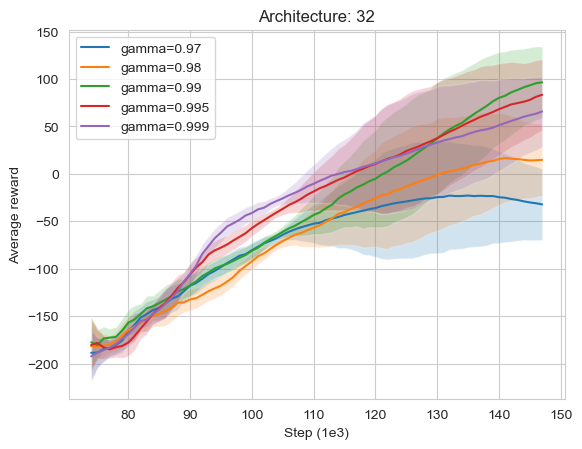

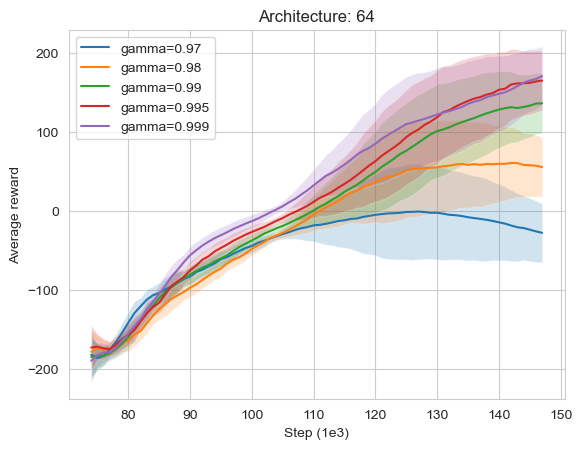

In [7]:
# first let's create plots for each architecture
for arch in archs:
    fig, ax = plt.subplots()
    for gamma in gammas:
        # plot the average and standard deviation on the same plot
        ax.plot(averages[arch['pi'][0]][gamma], label=f"gamma={gamma}")
        ax.fill_between(averages[arch['pi'][0]][gamma].index, averages[arch['pi'][0]][gamma] - std, averages[arch['pi'][0]][gamma] + std, alpha=0.2)
        # ax.plot(averages[arch['pi'][0]][gamma], label=f"gamma={gamma}")
    ax.set_title(f"Architecture: {arch['pi'][0]}")
    ax.set_xlabel("Step (1e3)")
    ax.set_ylabel("Average reward")
    ax.legend()
    plt.savefig(f"figures/average_rew_arch_{arch['pi'][0]}.png")

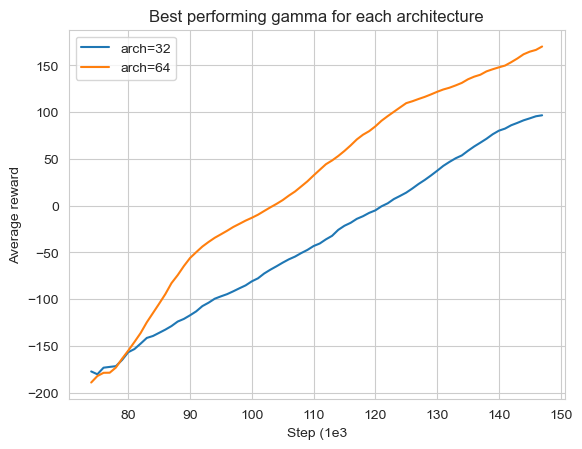

In [8]:
# now let's compare the best performing gamma for each architecture
# pick the best gamma for each architecture and then plot them on the same plot
best_gammas = {}
for arch in archs:
    best_gammas[arch['pi'][0]] = max(gammas, key=lambda gamma: averages[arch['pi'][0]][gamma].max())

fig, ax = plt.subplots()
for arch in archs:
    ax.plot(averages[arch['pi'][0]][best_gammas[arch['pi'][0]]], label=f"arch={arch['pi'][0]}")
ax.set_title(f"Best performing gamma for each architecture")
ax.set_xlabel("Step (1e3")
ax.set_ylabel("Average reward")
ax.legend()
plt.savefig(f"figures/average_rew_best_gamma.png")

# Exploration vs exploitation

In [9]:
import json

rewards_deterministic = json.load(open("ppo_lunar_lander_rewards_best.json", "r"))

average_rewards_deterministic = [np.sum(episode) for episode in rewards_deterministic]

average_over_all_episodes = np.mean(average_rewards_deterministic)
print(f"Average reward over all episodes: {average_over_all_episodes}")

Average reward over all episodes: 194.44204969219834


In [11]:
# we need to get the best average reward for the best model and compare it to exploitation

best_avg_exploitation = averages[arch['pi'][0]][best_gammas[arch['pi'][0]]].max()
print(f"Best average reward for the best model during training is: {best_avg_exploitation}")

Best average reward for the best model during training is: 170.14280319213867


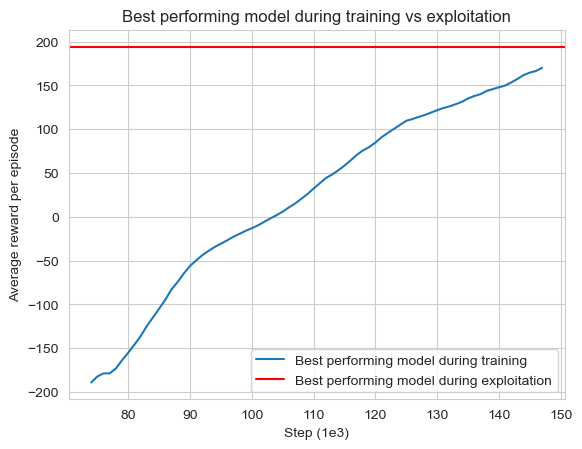

In [12]:
# let's create a plot on which we will plot the average reward for each episode and also a horizontal line which will be representing the average performance of the best model during exploitation

fig, ax = plt.subplots()
ax.plot(averages[arch['pi'][0]][best_gammas[arch['pi'][0]]], label="Best performing model during training")
ax.axhline(y=average_over_all_episodes, color='r', linestyle='-', label="Best performing model during exploitation")
ax.set_title(f"Best performing model during training vs exploitation")
ax.set_xlabel("Step (1e3)")
ax.set_ylabel("Average reward per episode")
ax.legend()
plt.savefig(f"figures/average_rew_best_model_vs_exploitation.png")
